In [1]:
import optuna
import xgboost as xgb
from sklearn.metrics import label_ranking_average_precision_score

import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v10_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v10_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000125c737df1802b6e365f93c96d3c8,7531,0,0,-1,0,0,-1,-1,0,0,97.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,132.0,1158.5,33.0,10.0,10.0,7.0,5,12,15,19,97420,28008,22512,15711,953,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.028802,0.028005
1,000125c737df1802b6e365f93c96d3c8,441,0,1,-1,0,0,-1,-1,0,0,314.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,161.0,714.5,16.0,7.0,7.0,4.0,5,12,15,19,97420,28008,22512,15711,958,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.032295,0.031288
2,000125c737df1802b6e365f93c96d3c8,2480,0,2,-1,0,0,-1,-1,0,0,144.0,1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,142.0,961.5,23.0,9.0,9.0,6.0,5,12,15,19,97420,28008,22512,15711,941,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.028136,0.027376
3,000125c737df1802b6e365f93c96d3c8,13240,0,3,-1,0,0,-1,-1,0,0,150.0,1.0,1,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,123.0,1340.0,38.0,11.0,11.0,8.0,5,12,15,19,97420,28008,22512,15711,558,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.027888,0.027165
4,000125c737df1802b6e365f93c96d3c8,10378,1,4,-1,0,0,-1,-1,0,0,264.0,1.0,1,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,109.0,1679.5,47.0,15.0,15.0,10.0,5,12,15,19,97420,28008,22512,15711,474,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.035129,0.033974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.040404,0.038787,0.016129,0.015955
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.040404,0.038787,0.019737,0.019411
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.036554,0.035222,0.025794,0.025178
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


In [ ]:
# ver1では一旦無視
# Ranking学習の場合、Taregetの数字を変える
# 1を1に、0を2に変える
# train_label['target'] = train_label['target'].replace(0, 2)

### Optunaでハイパラ探索

In [5]:
import optuna
import xgboost as xgb
from sklearn.metrics import label_ranking_average_precision_score

# 特徴量とターゲットの定義
features = [x for x in train_df.columns if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')]
target = 'target'

# XGBoost のパラメータ（GPU使用）
params = {
    'objective': 'rank:pairwise',  # ランキングタスク用の目的関数
    'eval_metric': 'map',  # MAPを評価指標とする
    'learning_rate': 0.05,
    'max_depth': 6,
    'seed': 42531,
    'tree_method': 'gpu_hist'  # GPUを使用するための設定
}

In [6]:
def objective(trial):
    # Optunaで探索するパラメータの設定
    param = {
        'objective': 'rank:pairwise',
        'eval_metric': 'map',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'seed': 42531,
        'tree_method': 'gpu_hist'
    }
    
    map_scores = []
    for fold in range(5):
        # トレーニングデータとバリデーションデータの分割
        train_data = train_df[train_df['fold'] != fold]
        valid_data = train_df[train_df['fold'] == fold]

        # XGBoostデータセットを作成
        dtrain = xgb.DMatrix(train_data[features], label=train_data[target])
        dvalid = xgb.DMatrix(valid_data[features], label=valid_data[target])

        # モデルの訓練
        model = xgb.train(param, dtrain, num_boost_round=30000, evals=[(dvalid, 'eval')], early_stopping_rounds=100, verbose_eval=0)

        # バリデーションデータでの予測と評価
        valid_pred = model.predict(dvalid)
        map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
        map_scores.append(map_score)

    # 平均MAPスコアを返す
    return np.mean(map_scores)

In [7]:
# Optunaのスタディを作成
study = optuna.create_study(direction='maximize')
# 15分で最適化を終了する
study.optimize(objective, timeout=900)
# 最適なパラメータを表示
print('Best trial:', study.best_trial.params)

[I 2023-12-16 12:20:36,430] A new study created in memory with name: no-name-3a7de572-e6f5-429f-9cf5-af4e5bbd082f
[I 2023-12-16 12:23:42,327] Trial 0 finished with value: 0.1199894225047006 and parameters: {'learning_rate': 0.09396697839615076, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9183537554440431, 'colsample_bytree': 0.8115402399914682, 'gamma': 0.3361811498929951, 'reg_alpha': 0.11899923941010848, 'reg_lambda': 0.9380833068392841}. Best is trial 0 with value: 0.1199894225047006.
[I 2023-12-16 12:27:35,051] Trial 1 finished with value: 0.11848788802247108 and parameters: {'learning_rate': 0.0986604473394323, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7158350060005177, 'colsample_bytree': 0.682915796009961, 'gamma': 1.7399560196280266, 'reg_alpha': 0.4027516881578779, 'reg_lambda': 0.7899554272059653}. Best is trial 0 with value: 0.1199894225047006.
[I 2023-12-16 12:32:53,083] Trial 2 finished with value: 0.11968787989376577 and parameters: {'learning_rate':

Best trial: {'learning_rate': 0.09396697839615076, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9183537554440431, 'colsample_bytree': 0.8115402399914682, 'gamma': 0.3361811498929951, 'reg_alpha': 0.11899923941010848, 'reg_lambda': 0.9380833068392841}


### XGboost Ranker（candidate用のRankerモデル）

In [5]:
import xgboost as xgb
from sklearn.metrics import label_ranking_average_precision_score

# 特徴量とターゲットの定義
features = [x for x in train_df.columns if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')]
target = 'target'

params = {
    'objective': 'rank:pairwise',  # ランキングタスク用の目的関数
    'eval_metric': 'map',  # MAPを評価指標とする
    'learning_rate': 0.09396697839615076, 
    'max_depth': 8, 
    'min_child_weight': 9, 
    'subsample': 0.9183537554440431, 
    'colsample_bytree': 0.8115402399914682, 
    'gamma': 0.3361811498929951, 
    'reg_alpha': 0.11899923941010848, 
    'reg_lambda': 0.9380833068392841,
    'seed': 42531,
    'tree_method': 'gpu_hist'  # GPUを使用するための設定
}

In [6]:
map_scores = []
test_pred = []
oof_pred = np.zeros(len(train_df))

for fold in range(10):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # XGBoostデータセットを作成
    dtrain = xgb.DMatrix(train_data[features], label=train_data[target])
    dvalid = xgb.DMatrix(valid_data[features], label=valid_data[target])

    # モデルの訓練
    model = xgb.train(params, dtrain, num_boost_round=30000, evals=[(dvalid, 'eval')], early_stopping_rounds=100, verbose_eval=1000)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(dvalid)
    oof_pred[valid_data.index] = valid_pred
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    dtest = xgb.DMatrix(test_df[features])
    test_pred.append(model.predict(dtest))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


[0]	eval-map:0.10091
[1000]	eval-map:0.14499
[2000]	eval-map:0.15382
[2647]	eval-map:0.15441
Fold 0: MAP = 0.15434433167899983
[0]	eval-map:0.10152
[1000]	eval-map:0.14487
[2000]	eval-map:0.15297
[2215]	eval-map:0.15299
Fold 1: MAP = 0.1529347218558509
[0]	eval-map:0.09910
[1000]	eval-map:0.14409
[2000]	eval-map:0.15075
[2013]	eval-map:0.15075
Fold 2: MAP = 0.15069300744881622
[0]	eval-map:0.10115
[1000]	eval-map:0.14802
[2000]	eval-map:0.15556
[2358]	eval-map:0.15582
Fold 3: MAP = 0.15573258091095413
[0]	eval-map:0.09992
[1000]	eval-map:0.14445
[2000]	eval-map:0.15232
[2528]	eval-map:0.15312
Fold 4: MAP = 0.15305933210043834
[0]	eval-map:0.09691
[1000]	eval-map:0.14029
[2000]	eval-map:0.14781
[2321]	eval-map:0.14812
Fold 5: MAP = 0.14805327085481115
[0]	eval-map:0.09919
[1000]	eval-map:0.14495
[2000]	eval-map:0.15255
[2455]	eval-map:0.15340
Fold 6: MAP = 0.1533398004085299
[0]	eval-map:0.09749
[1000]	eval-map:0.14300
[2000]	eval-map:0.15047
[2202]	eval-map:0.15068
Fold 7: MAP = 0.1506

           Feature  Importance
2       max_seq_no  102.843048
33   TE_sml_cd_var   65.543396
32  TE_sml_cd_mean   45.461468
23    count_lrg_cd   38.313507
25   count_yado_no   34.428993


<Figure size 720x432 with 0 Axes>

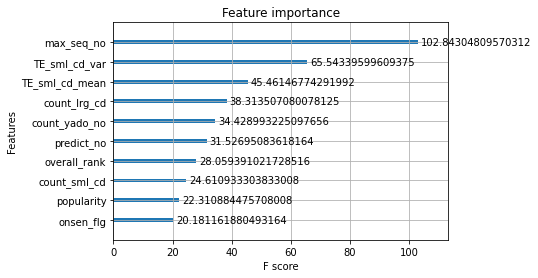

In [7]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# 以下はモデルの訓練コードと同様
# ...

# 特徴量重要度の取得
feature_importances = model.get_score(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importances_df = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# 重要度が高い上位の特徴量を表示
print(feature_importances_df.head())

# 特徴量重要度のグラフ表示
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.show()

In [8]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [9]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.165627
1,000125c737df1802b6e365f93c96d3c8,441,0.176169
2,000125c737df1802b6e365f93c96d3c8,2480,0.699587
3,000125c737df1802b6e365f93c96d3c8,13240,0.500891
4,000125c737df1802b6e365f93c96d3c8,10378,0.346591


In [10]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.165627
1,000125c737df1802b6e365f93c96d3c8,441,0.176169
2,000125c737df1802b6e365f93c96d3c8,2480,0.699587
3,000125c737df1802b6e365f93c96d3c8,13240,0.500891
4,000125c737df1802b6e365f93c96d3c8,10378,0.346591
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-9.314261
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-7.432692
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-6.161829
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-10.042168


In [11]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.165627
1,000125c737df1802b6e365f93c96d3c8,441,0.176169
2,000125c737df1802b6e365f93c96d3c8,2480,0.699587
3,000125c737df1802b6e365f93c96d3c8,13240,0.500891
4,000125c737df1802b6e365f93c96d3c8,10378,0.346591
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-9.314261
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-7.432692
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-6.161829
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-10.042168


In [12]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/xgbRanker_ver8_oof_pred.csv', index=False)

In [13]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.165627
1,000125c737df1802b6e365f93c96d3c8,441,0.176169
2,000125c737df1802b6e365f93c96d3c8,2480,0.699587
3,000125c737df1802b6e365f93c96d3c8,13240,0.500891
4,000125c737df1802b6e365f93c96d3c8,10378,0.346591
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-9.314261
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-7.432692
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-6.161829
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-10.042168


### CVの計算

In [14]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [15]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [16]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 11380, 1284, 5490, 254, 4072, 12491]
CPU times: user 180 ms, sys: 11 µs, total: 180 ms
Wall time: 184 ms


In [17]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:51<00:00, 5633.59it/s]


In [18]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,5289,997,2808,4101,11882,12846,3324,9208,9209,9207
1,2570,1586,11104,2259,4488,3564,3725,8747,8253,8225
2,4863,9039,6722,1967,4355,5238,13642,7509,2957,11724
3,626,109,7812,13549,755,11715,13296,1341,7872,2272
4,96,3894,7749,902,11380,1284,5490,254,4072,12491
...,...,...,...,...,...,...,...,...,...,...
288693,5719,3725,13717,13079,1586,10522,10955,2876,13210,8677
288694,513,2900,4767,399,6654,8465,5299,963,3940,8703
288695,7820,2087,3566,4398,844,9558,7308,4040,10364,12240
288696,10619,11091,12500,570,7551,3238,12781,10616,12829,11316


### 要素の集合にバグがないかを確認

In [19]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [20]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムの数を確認する

In [21]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [22]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
288078


In [23]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [24]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,5289,997,2808,4101,11882,12846,3324,9208,9209,9207
1,2570,1586,11104,2259,4488,3564,3725,8747,8253,8225
2,4863,9039,6722,1967,4355,5238,13642,7509,2957,11724
3,626,109,7812,13549,755,11715,13296,1341,7872,2272
4,96,3894,7749,902,11380,1284,5490,254,4072,12491
5,4823,12544,10510,5369,9199,9207,9202,9200,9201,1
6,4574,10442,2480,13240,10378,441,7531,7273,12774,2282
7,10362,12125,7681,12464,4744,9508,12962,111,1755,10544
8,12432,3644,3802,4014,13220,899,2164,1227,9723,13702
9,10478,6592,4303,9773,550,3483,379,3278,9430,2806


In [25]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [26]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [27]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.4540042159176167


In [28]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [29]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [30]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,5289,997,2808,4101,11882,12846,3324,9208,9209,9207,False
1,2570,1586,11104,2259,4488,3564,3725,8747,8253,8225,False
2,4863,9039,6722,1967,4355,5238,13642,7509,2957,11724,False
3,626,109,7812,13549,755,11715,13296,1341,7872,2272,False
4,96,3894,7749,902,11380,1284,5490,254,4072,12491,False


### 推論用の候補テーブル作成

In [31]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [32]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.5976249  -0.6791142   0.26082313 ...  0.22550595  0.4460551
  0.31428915]
1683604


In [33]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(10, 1683604)


In [34]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [35]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.597625
1,00001149e9c73985425197104712478c,4714,-0.679114
2,00001149e9c73985425197104712478c,2680,0.260823
3,00001149e9c73985425197104712478c,4420,-1.481933
4,00001149e9c73985425197104712478c,5466,-0.492628


In [36]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.597625
1,00001149e9c73985425197104712478c,4714,-0.679114
2,00001149e9c73985425197104712478c,2680,0.260823
3,00001149e9c73985425197104712478c,4420,-1.481933
4,00001149e9c73985425197104712478c,5466,-0.492628
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.428316
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.378359
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.225506
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.446055


In [37]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.597625
1,00001149e9c73985425197104712478c,4714,-0.679114
2,00001149e9c73985425197104712478c,2680,0.260823
3,00001149e9c73985425197104712478c,4420,-1.481933
4,00001149e9c73985425197104712478c,5466,-0.492628
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.428316
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.378359
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.225506
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.446055


In [38]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.597625
1,00001149e9c73985425197104712478c,4714,-0.679114
2,00001149e9c73985425197104712478c,2680,0.260823
3,00001149e9c73985425197104712478c,4420,-1.481933
4,00001149e9c73985425197104712478c,5466,-0.492628
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.428316
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.378359
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.225506
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.446055


In [39]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/xgbRanker_ver8_test_pred.csv', index=False)

In [40]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [41]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[10729, 634, 12767, 5623, 3781, 867, 12620, 11994, 11723, 1891]
CPU times: user 89 ms, sys: 7.95 ms, total: 97 ms
Wall time: 97.5 ms


In [42]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:27<00:00, 6449.40it/s]


In [43]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,5466,4714,4420,9830,9534,5785,6563
1,11237,12862,7014,6555,8108,4066,11923,143,6129,613
2,757,9190,9910,7710,6721,410,1774,10485,6730,13570
3,12341,3359,6991,13521,1542,10861,4180,5080,10746,6489
4,10826,6161,3476,5372,9623,2862,3844,9020,3854,12029
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,10042,3440,9743
174696,12432,1227,4014,3802,3644,13220,899,9723,2164,13702
174697,2087,7308,11796,8143,13241,13719,13797,12939,11037,5810
174698,2692,5513,2373,12281,3002,10287,13672,4976,1687,3100


In [44]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [45]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [46]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [47]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


In [48]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [49]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,5466,4714,4420,9830,9534,5785,6563,False
1,11237,12862,7014,6555,8108,4066,11923,143,6129,613,False
2,757,9190,9910,7710,6721,410,1774,10485,6730,13570,False
3,12341,3359,6991,13521,1542,10861,4180,5080,10746,6489,False
4,10826,6161,3476,5372,9623,2862,3844,9020,3854,12029,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,10042,3440,9743,False
174696,12432,1227,4014,3802,3644,13220,899,9723,2164,13702,False
174697,2087,7308,11796,8143,13241,13719,13797,12939,11037,5810,False
174698,2692,5513,2373,12281,3002,10287,13672,4976,1687,3100,False


In [50]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/xgbRanker_ver8.csv', index=False)